In [1]:
using Random
using Distributions
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/DF_GMVI.jl")
include("./MultiModal.jl")
Random.seed!(111);

# Hyperparameter Test

We test the sensitivity of DF-GMVI on  $\alpha$ and $\Delta t$ using the follow double banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)\\ 
\theta_{(1)}\\ 
\theta_{(2)}
\end{bmatrix}
+ \eta \quad(\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
\log(\lambda+1)\\
0\\
0
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 & \\
& 1^2   \\
& & 1^2
\end{bmatrix}  
\end{align*}
$$

We essentially focus on the prior $\mathcal{N}(0,I)$, and we are sampling 
$e^{-\frac{1}{2}F^TF}$ 
with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)}{\sigma_\eta}\\
y_{(2)} - \theta_{(1)}\\
y_{(3)} - \theta_{(2)}
\end{bmatrix}$$

- Sensitivity on $\alpha$: test $\alpha = 10^{-1}, 10^{-3}, 10^{-5}$
- Sensitivity on $\Delta t$: test $\Delta t = 0.25, 0.50, 0.75$

In [2]:
function visualization_param_2d(ax, objs; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
    func_F = nothing, func_Phi = nothing, label = nothing)

    x_min, x_max = x_lim
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

    Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
    color_lim = (minimum(Z_ref), maximum(Z_ref))

    N_obj = length(objs)
    N_iter = length(objs[1].logx_w) - 1
    error = zeros(N_obj, N_iter+1)

    for (iobj, obj) in enumerate(objs)
        
        for iter = 0:N_iter  
            x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj.x_mean[iter+1][:,1:2]
            xx_cov = obj.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[iobj, iter+1] = norm(Z - Z_ref,1)*dx*dy
        end
    
    end

    markers = ["o", "s", "^", "v", ">", "<", "D", "p", "*"]

    for i_obj = 1:N_obj
        ax.semilogy(Array(0:N_iter), error[i_obj, :], label = label[i_obj], marker=markers[i_obj], markevery=div(N_iter,10), markerfacecolor="none")
    end
    # Get the current y-axis limits
    ymin, ymax = ax.get_ylim()
    # Ensure the lower bound of y-ticks is below 0.1
    if ymin > 0.1
        ax.set_ylim(0.1, ymax)  # Set the lower limit to a value below 0.1
    end
    if label!==nothing 
        ax.legend()
    end
end

visualization_param_2d (generic function with 1 method)

[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("ite

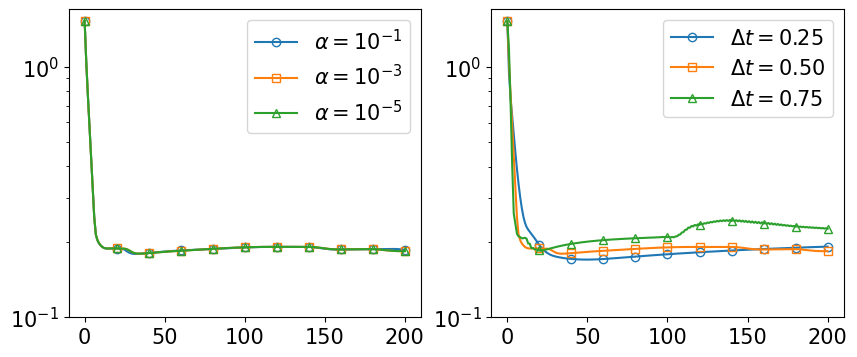

In [3]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, sharex=false, sharey=false, figsize=(10,4))

N_modes = 40
N_x = 2
N_iter = 200
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = zeros(N_x), Diagonal(ones(N_x))
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end

alpha_array = [1.0e-1, 1.0e-3, 1.0e-4]
dt_array = [0.25, 0.50, 0.75]

ση = [0.3; 1.0; 1.0; ones(N_x-2)]
Gtype = "Double_banana"
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
objs1 = [Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 0.5, c_weight_BIP = alpha)[1] 
        for alpha in alpha_array]
objs2 = [Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1] 
        for dt in dt_array]
# compute marginal distribution
y_2d, ση_2d = y[1:3], ση[1:3]
func_args = (y_2d, ση_2d, λ , Gtype)
func_F(x) = F(x, func_args)


visualization_param_2d(ax[1], objs1; func_F = func_F, label = [L"\alpha = 10^{-1}", L"\alpha = 10^{-3}", L"\alpha = 10^{-5}" ])
visualization_param_2d(ax[2], objs2; func_F = func_F, label = [L"\Delta t = 0.25", L"\Delta t = 0.50", L"\Delta t = 0.75" ])

# fig.tight_layout()
fig.savefig("DF-GMVI-param-test.pdf")